# Hello, KAN!

### Kolmogorov-Arnold representation theorem

Kolmogorov-Arnold representation theorem states that if $f$ is a multivariate continuous function
on a bounded domain, then it can be written as a finite composition of continuous functions of a
single variable and the binary operation of addition. More specifically, for a smooth $f : [0,1]^n \to \mathbb{R}$,


$$f(x) = f(x_1,...,x_n)=\sum_{q=1}^{2n+1}\Phi_q(\sum_{p=1}^n \phi_{q,p}(x_p))$$

where $\phi_{q,p}:[0,1]\to\mathbb{R}$ and $\Phi_q:\mathbb{R}\to\mathbb{R}$. In a sense, they showed that the only true multivariate function is addition, since every other function can be written using univariate functions and sum. However, this 2-Layer width-$(2n+1)$ Kolmogorov-Arnold representation may not be smooth due to its limited expressive power. We augment its expressive power by generalizing it to arbitrary depths and widths.

### Kolmogorov-Arnold Network (KAN)

The Kolmogorov-Arnold representation can be written in matrix form

$$f(x)={\bf \Phi}_{\rm out}\circ{\bf \Phi}_{\rm in}\circ {\bf x}$$

where 

$${\bf \Phi}_{\rm in}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n}(\cdot) \\ \vdots & & \vdots \\ \phi_{2n+1,1}(\cdot) & \cdots & \phi_{2n+1,n}(\cdot) \end{pmatrix},\quad {\bf \Phi}_{\rm out}=\begin{pmatrix} \Phi_1(\cdot) & \cdots & \Phi_{2n+1}(\cdot)\end{pmatrix}$$

We notice that both ${\bf \Phi}_{\rm in}$ and ${\bf \Phi}_{\rm out}$ are special cases of the following function matrix ${\bf \Phi}$ (with $n_{\rm in}$ inputs, and $n_{\rm out}$ outputs), we call a Kolmogorov-Arnold layer:

$${\bf \Phi}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n_{\rm in}}(\cdot) \\ \vdots & & \vdots \\ \phi_{n_{\rm out},1}(\cdot) & \cdots & \phi_{n_{\rm out},n_{\rm in}}(\cdot) \end{pmatrix}$$

${\bf \Phi}_{\rm in}$ corresponds to $n_{\rm in}=n, n_{\rm out}=2n+1$, and ${\bf \Phi}_{\rm out}$ corresponds to $n_{\rm in}=2n+1, n_{\rm out}=1$.

After defining the layer, we can construct a Kolmogorov-Arnold network simply by stacking layers! Let's say we have $L$ layers, with the $l^{\rm th}$ layer ${\bf \Phi}_l$ have shape $(n_{l+1}, n_{l})$. Then the whole network is

$${\rm KAN}({\bf x})={\bf \Phi}_{L-1}\circ\cdots \circ{\bf \Phi}_1\circ{\bf \Phi}_0\circ {\bf x}$$

In constrast, a Multi-Layer Perceptron is interleaved by linear layers ${\bf W}_l$ and nonlinearities $\sigma$:

$${\rm MLP}({\bf x})={\bf W}_{L-1}\circ\sigma\circ\cdots\circ {\bf W}_1\circ\sigma\circ {\bf W}_0\circ {\bf x}$$

A KAN can be easily visualized. (1) A KAN is simply stack of KAN layers. (2) Each KAN layer can be visualized as a fully-connected layer, with a 1D function placed on each edge. Let's see an example below.

### Get started with KANs

Initialize KAN

In [87]:
# imports
import gc
import torch
import numpy as np
from kan import *
import sys
import copy

In [88]:
# check memory if its not emptying
torch.set_default_dtype(torch.float32)
gc.collect()

# Get all objects tracked by the garbage collector
all_objects = gc.get_objects()

# Filter for torch tensors
tensors = [obj for obj in all_objects if torch.is_tensor(obj)]

# Print details about each tensor
for i, obj in enumerate(gc.get_objects()):
    if torch.is_tensor(obj):
        #print(f"Tensor {i}: shape={obj.shape}, dtype={obj.dtype}, device={obj.device}")
        del obj
torch.cuda.empty_cache()

In [95]:
path1 = r"C:\Users\ingoa\Documents\GitHub\simpl-energy-KAN-do-it\ingo fikt\ElectricDevices_TRAIN.txt"
path2 = r"C:\Users\ingoa\Documents\GitHub\simpl-energy-KAN-do-it\ingo fikt\ElectricDevices_TEST.txt"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    torch.set_default_device(device)
else:
    torch.set_default_tensor_type(torch.FloatTensor)



def load_data(filepath):
    """
    Helper function to load data from a text file.
    Assumes each line of the file is a time series row.
    """
    with open(filepath, 'r') as file:
        data = file.readlines()
    return data

def split_and_combine_data(path1, path2, split_index=6047):
    # Load data from both paths
    data1 = load_data(path1)
    data2 = load_data(path2)

    # Split data from path2
    path2_train_data = data2[:split_index]  # First 6047 lines for training
    path2_test_data = data2[split_index:]   # Remaining lines for testing

    # Combine path1 data with first part of path2 data for training
    training_data = data1 + path2_train_data

    return training_data, path2_test_data

def prepare_datasets(path1, path2, split_index=6047):
    # Split and combine the data
    training_data, test_data = split_and_combine_data(path1, path2, split_index)

    # Convert data into suitable format for kan.utils.create_dataset
    # Assuming the first column is the label and the rest is the time series data
    train_labels = []
    train_series = []
    test_labels = []
    test_series = []

    # Process training data
    for line in training_data:
        values = line.strip().split()  # Split by spaces
        train_labels.append(float(values[0]))  # First column is the label
        train_series.append([float(x) for x in values[1:]])  # Rest are time series data

    # Process test data
    for line in test_data:
        values = line.strip().split()
        test_labels.append(float(values[0]))
        test_series.append([float(x) for x in values[1:]])

    return torch.tensor(train_series), torch.tensor(train_labels), torch.tensor(test_series), torch.tensor(test_labels)


# Prepare the datasets

dataset = {}
dataset['train_input'], dataset['train_label'], dataset['test_input'], dataset['test_label'] = prepare_datasets(path1, path2, split_index=0)
dataset['train_label'] = dataset['train_label'].reshape(dataset['train_label'].shape[0], 1)
dataset['test_label'] = dataset['test_label'].reshape(dataset['test_label'].shape[0], 1)

In [96]:
all_labels_original = copy.deepcopy(torch.cat((dataset['train_label'],dataset['test_label']),dim=0).flatten().tolist())

In [97]:
print(dataset['train_input'].shape)
print(dataset['train_label'].shape)
print(dataset['test_input'].shape)
print(dataset['test_label'].shape)

torch.Size([8926, 96])
torch.Size([8926, 1])
torch.Size([7711, 96])
torch.Size([7711, 1])


In [98]:
def compress_list_by_average(data, factor=8):
    compressed_data = []
    
    # Iterate over each sub-list in the data
    for sublist in data:
        # Reshape the sublist into (12, 8) shape and compute the mean along axis 1
        if isinstance(sublist, np.float64): 
                break
        
        compressed_sublist = []
        for i in range(0, len(sublist), factor):
            
            sub = sublist[i:i+factor]
            compressed_sublist.append(np.mean(sub.detach().numpy()))
        compressed_data.append(compressed_sublist)
        
    return compressed_data

#All Factors of 96:
#1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 96
# Compress each sub-list by a factor of 8 (using average)
dataset['train_input'] = torch.tensor(compress_list_by_average(dataset['train_input'].cpu(), factor=1))
dataset['test_input'] = torch.tensor(compress_list_by_average(dataset['test_input'].cpu(), factor=1))

In [99]:
dataset['train_input'].to(device)
dataset['train_label'].to(device)
dataset['test_input'].to(device)
dataset['test_label'].to(device)
print(device)
pass
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).

cuda


Train KAN with sparsity regularization

In [100]:
print(dataset['train_input'].shape)
print(dataset['train_label'].shape)
print(dataset['test_input'].shape)
print(dataset['test_label'].shape)

torch.Size([8926, 96])
torch.Size([8926, 1])
torch.Size([7711, 96])
torch.Size([7711, 1])


In [102]:
# input data normalization step
mean = dataset['train_input'].mean()
std = dataset['train_input'].std()

# Normalize the tensor
dataset['train_input'] = (dataset['train_input'] - mean) / std
dataset['test_input'] = (dataset['test_input'] - mean) / std


In [103]:
# label data one hot encoding step
# Number of classes for one-hot encoding (in this case, 8)
num_classes = 8

# Create one-hot encoding using torch.nn.functional

dataset['train_label'] = torch.nn.functional.one_hot(dataset['train_label'].long(), num_classes=num_classes)
dataset['test_label'] = torch.nn.functional.one_hot(dataset['test_label'].long(), num_classes=num_classes)
dataset['train_label'] = dataset['train_label'].float()
dataset['test_label'] = dataset['test_label'].float()

In [104]:
print(dataset['train_input'].shape)
print(dataset['train_label'].shape)
print(dataset['test_input'].shape)
print(dataset['test_label'].shape)

torch.Size([8926, 96])
torch.Size([8926, 1, 8])
torch.Size([7711, 96])
torch.Size([7711, 1, 8])


In [105]:
# Flatten the tensor along dimension 1 (channels)
dataset['train_label'] = torch.flatten(dataset['train_label'], start_dim=1)
dataset['test_label'] = torch.flatten(dataset['test_label'], start_dim=1)
print(dataset['train_input'].shape)
print(dataset['train_label'].shape)
print(dataset['test_input'].shape)
print(dataset['test_label'].shape)

torch.Size([8926, 96])
torch.Size([8926, 8])
torch.Size([7711, 96])
torch.Size([7711, 8])


In [154]:
# plot KAN at initialization
model = KAN(width=[dataset['train_input'].shape[1],4,4,4,4,8], grid=5, k=3, seed=3456, device=device)
print(f'using : {device}')
model.to(device)
model(dataset['train_input']);

checkpoint directory created: ./model
saving model version 0.0
using : cuda


In [ ]:
class MyKANModel(nn.Module):
    def __init__(self):
        super(MyKANModel, self).__init__()
        # Define your layers here
        self.fc = nn.Linear(in_features=768, out_features=10)  # Adjust in_features as needed
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc(x)
        x = self.softmax(x)  # Apply softmax after the linear layer
        return x

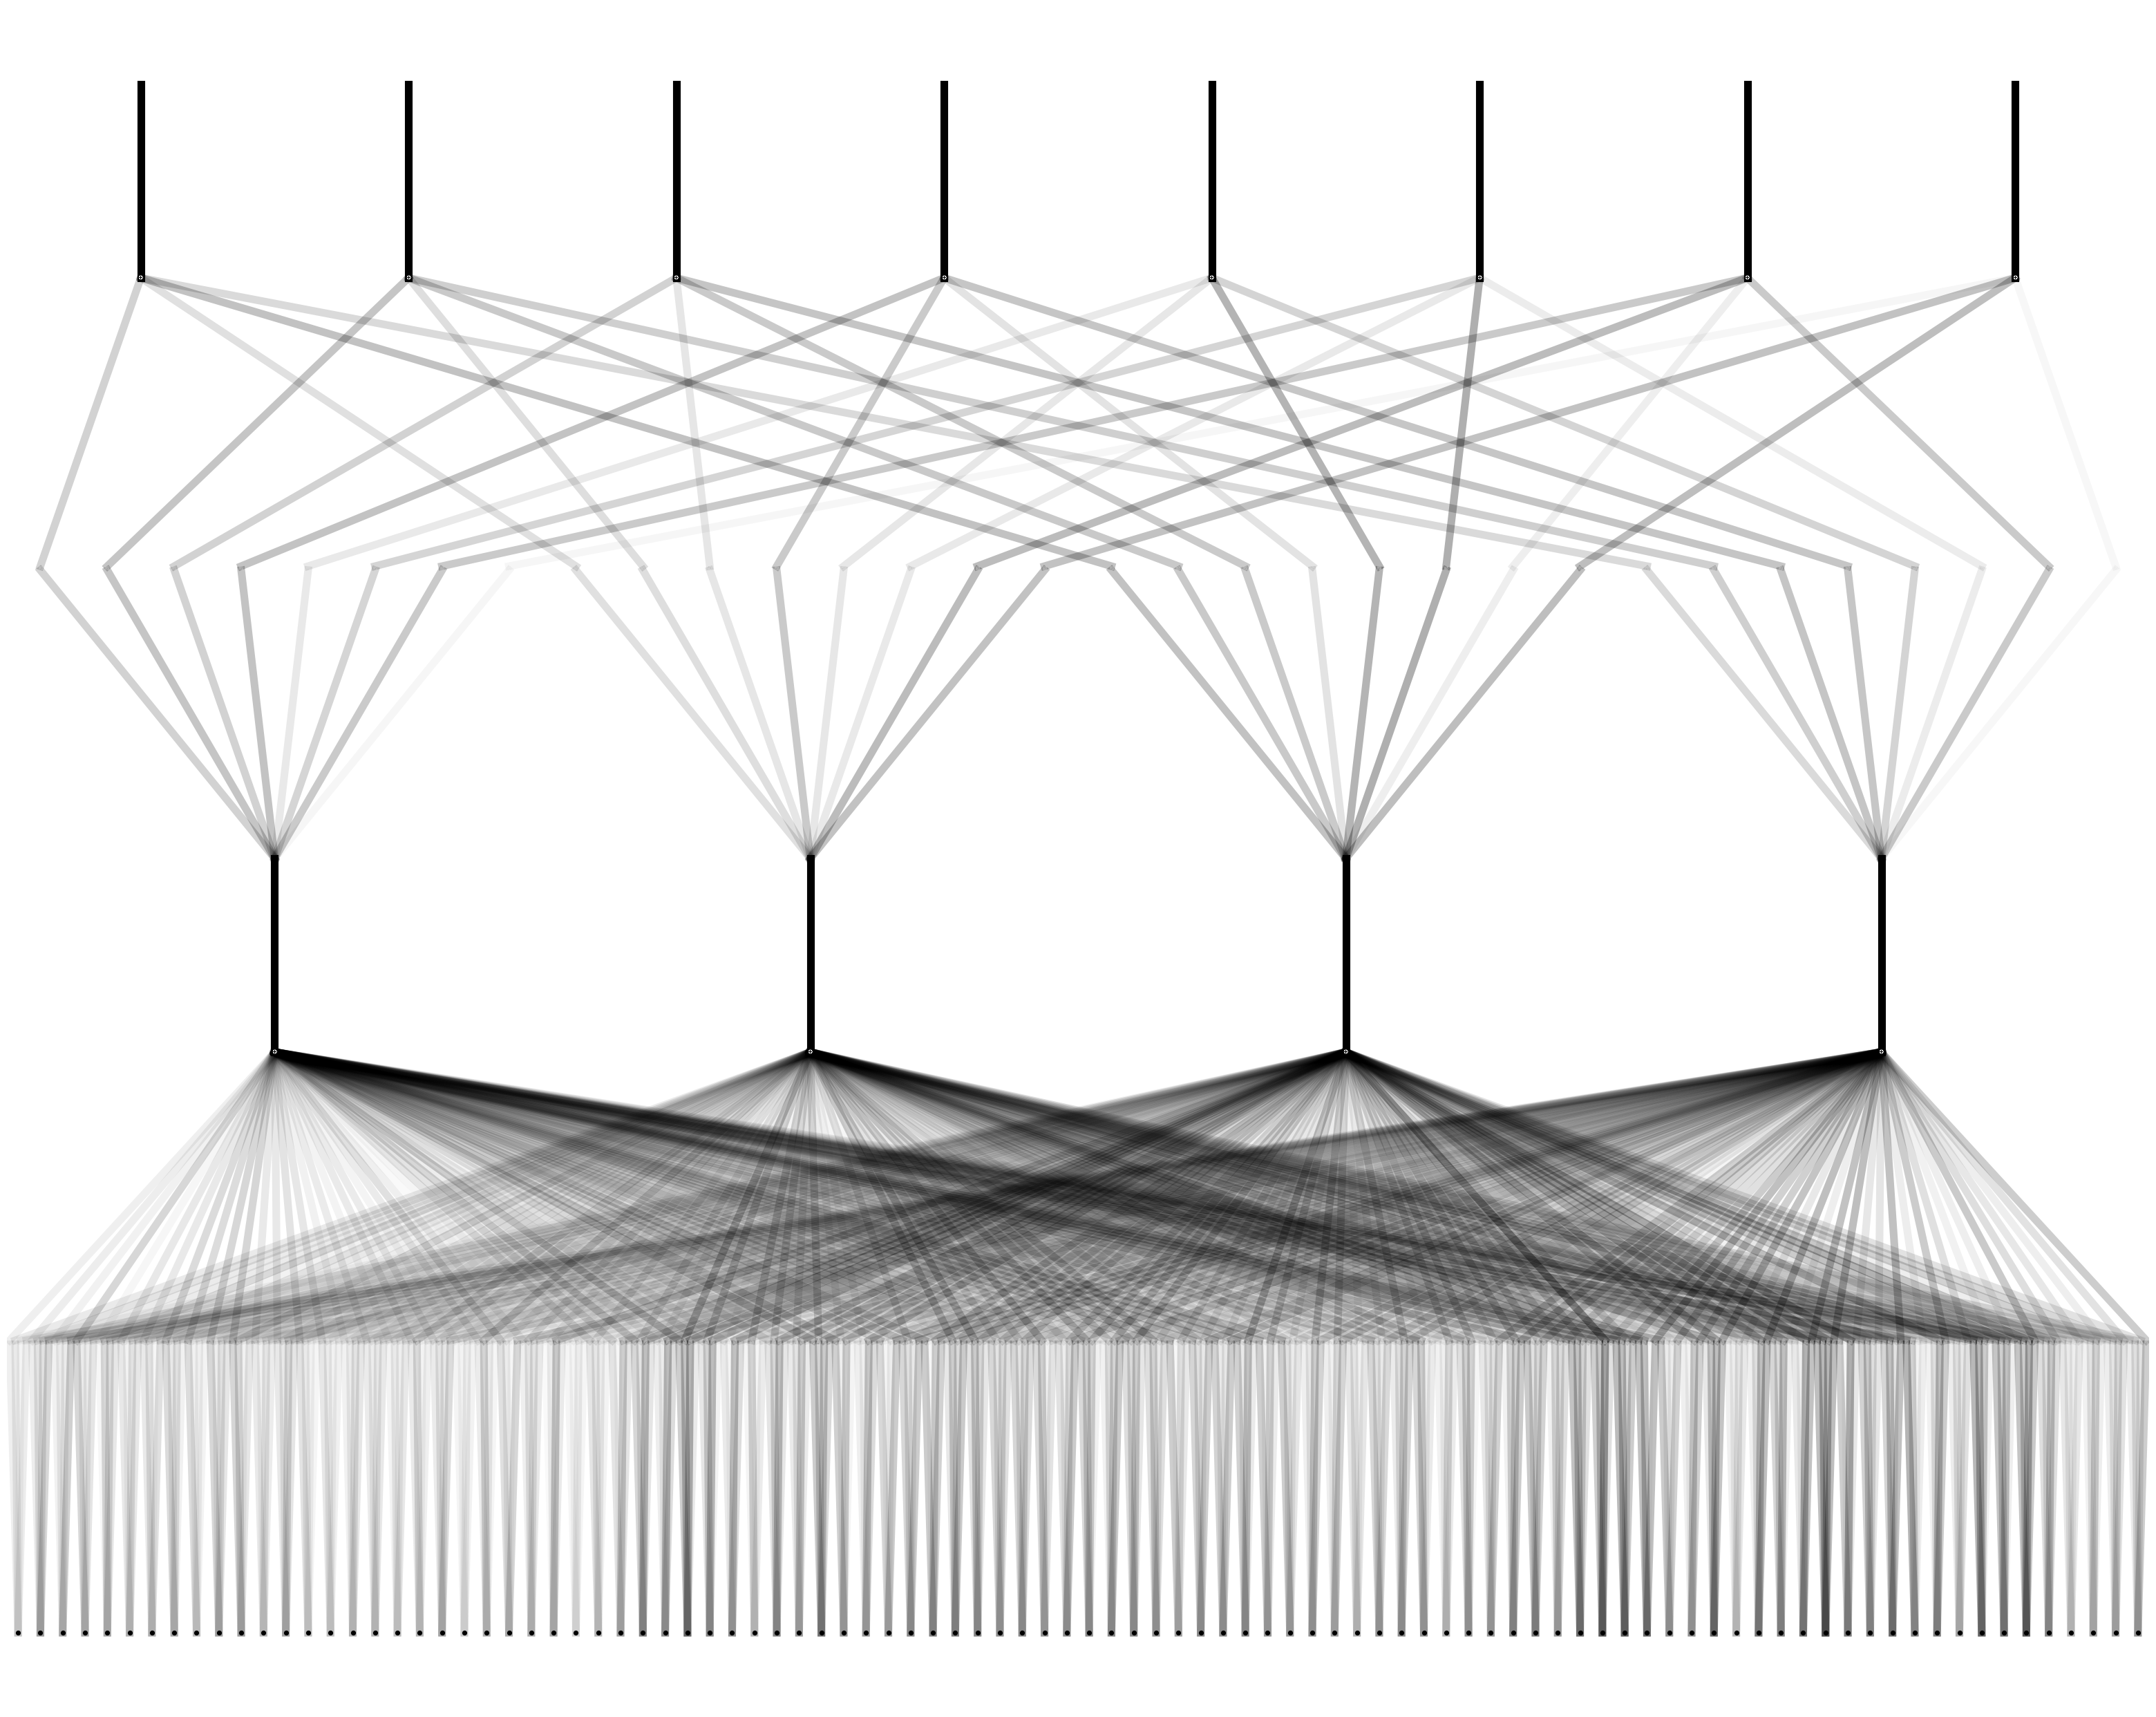

In [107]:
model.plot(scale=4.0)#,sample=True)

In [155]:
# train the model
model.save_act=True
results = model.fit(dataset, opt="Adam", steps=1000, lamb=0.001,lr = 0.01,batch=7711,loss_fn=nn.CrossEntropyLoss())
pass

| train_loss: 8.65e-01 | test_loss: 1.26e+00 | reg: 1.04e+02 | : 100%|█| 1000/1000 [02:33<00:00,  6.


saving model version 0.1


Plot trained KAN

Prune KAN and replot

saving model version 0.2


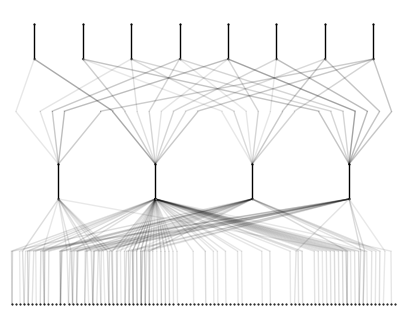

In [109]:
model = model.prune()
model.plot()
pass

Continue training and replot

In [24]:
model = model.speed()

In [153]:
# Assuming model.fit() returns a dictionary with lists for training loss, test loss, and regularization
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label'].T).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label'].T).float())

model.save_act=True
results = model.fit(dataset, opt="LBFGS", steps=100, loss_fn=torch.nn.CrossEntropyLoss(), lamb=0.001,lr = 0.01,batch=7711);


| train_loss: 9.28e-01 | test_loss: 1.16e+00 | reg: 5.02e+01 | : 100%|█| 100/100 [01:02<00:00,  1.59

saving model version 0.24


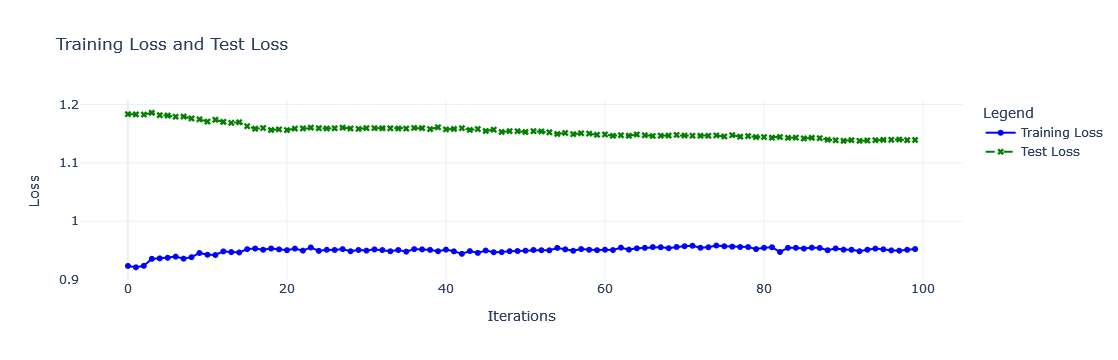

In [152]:
import plotly.graph_objects as go
# Get the values from the dictionary
train_loss = results['train_loss']
test_loss = results['test_loss']

# Create a figure
fig = go.Figure()

# Plot training loss
fig.add_trace(go.Scatter(
    x=list(range(len(train_loss))),
    y=train_loss,
    mode='lines+markers',
    name='Training Loss',
    line=dict(color='blue'),
    marker=dict(symbol='circle')
))

# Plot test loss
fig.add_trace(go.Scatter(
    x=list(range(len(test_loss))),
    y=test_loss,
    mode='lines+markers',
    name='Test Loss',
    line=dict(color='green', dash='dash'),
    marker=dict(symbol='x')
))

# Add labels and title
fig.update_layout(
    title='Training Loss and Test Loss',
    xaxis_title='Iterations',
    yaxis_title='Loss',
    legend_title='Legend',
    template='plotly_white',
    showlegend=True
)

# Add grid
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

# Show the plot
fig.show()


In [148]:
correct = 0
import time
model_guess = model(dataset['test_input'])
for index, label in enumerate(dataset["test_label"]):
    guess = model_guess[index]
    if model_guess.shape[1] == 1:
        guess = int(np.round(guess.item()))
        correct_answer = int(np.round(label.item()))
    else:
        guess = torch.argmax(guess)
        correct_answer = torch.argmax(label)
    if guess == correct_answer:
        correct += 1
    sys.stdout.write(f'\rAccuracy of model predictions on the test set : {correct/(index+1):.2}, Model Guess : {guess}, actual answer {correct_answer}')
    sys.stdout.flush() 

Accuracy of model predictions on the test set : 0.57, Model Guess : 5, actual answer 5

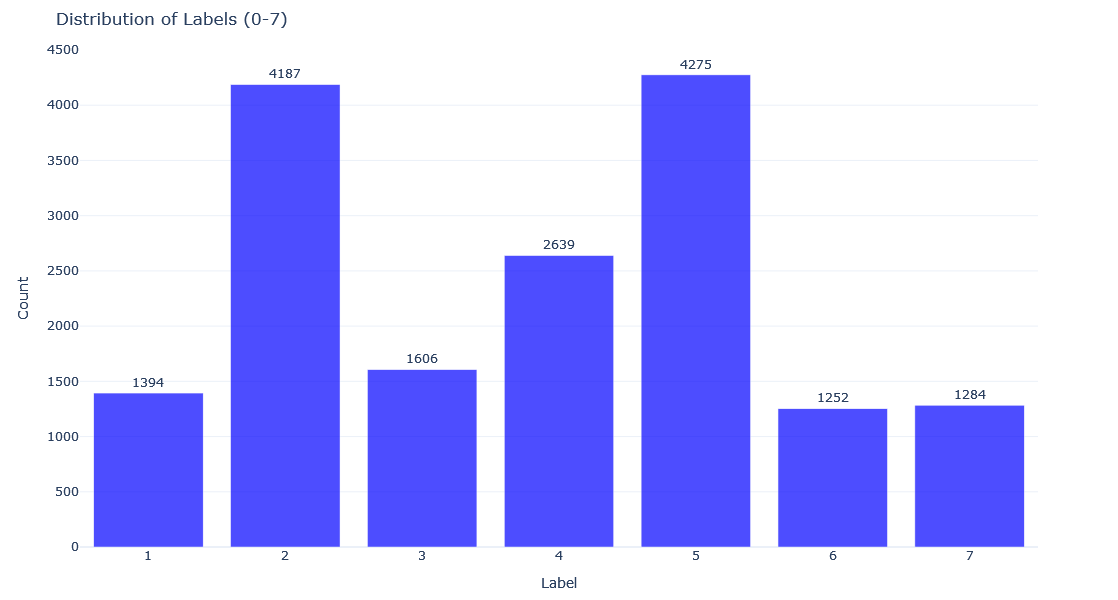

In [21]:
# Get the unique labels and their counts
labels, counts = torch.unique(torch.tensor(all_labels_original), return_counts=True)

# Create a bar plot
fig = go.Figure(data=[
    go.Bar(
        x=labels.tolist(), 
        y=counts.tolist(), 
        marker=dict(color='blue', opacity=0.7),
        text=counts.tolist(),  # Add counts above the bars
        textposition='outside',  # Position the text above the bars
        textfont=dict(size=12)  # Customize the text size
    )
])

# Add labels and title
fig.update_layout(
    title='Distribution of Labels (0-7)',
    xaxis_title='Label',
    yaxis_title='Count',
    template='plotly_white',  # White background for better contrast
    height=600,  # Increase figure height
    margin=dict(t=50, b=50)  # Adjust top and bottom margins
)

# Show the plot
fig.show()



In [22]:
model = model.refine(10)

saving model version 0.2


In [24]:
results = model.fit(dataset, opt="LBFGS", steps=200, lr=0.1);

| train_loss: 1.35e+00 | test_loss: 1.34e+00 | reg: 0.00e+00 | :  22%|▏| 43/200 [00:19<01:12,  2.18i


KeyboardInterrupt: 

In [50]:
results = model.fit(dataset, opt="LBFGS", steps=1000, loss_fn=torch.nn.CrossEntropyLoss(), lamb=0.001,lr = 0.01);

| train_loss: 1.10e+00 | test_loss: 1.11e+00 | reg: 5.10e+01 | : 100%|█| 1000/1000 [02:55<00:00,  5.

saving model version 0.7


In [100]:
model = model.rewind('0.2')

rewind to model version 0.2, renamed as 1.2


Automatically or manually set activation functions to be symbolic

In [ ]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

Continue training till machine precision

In [ ]:
model.fit(dataset, opt="LBFGS", steps=50);

Obtain the symbolic formula

In [ ]:
from kan.utils import ex_round

ex_round(model.symbolic_formula()[0][0],4)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'dataset' is already loaded and 'model' is a trained model
# dataset["train_input"] shape: (num_samples, 2) -> x and y
# dataset["train_label"] shape: (num_samples,) -> z (true labels)

everyOther = 1
# Extract x, y from dataset["train_input"] and z from dataset["train_label"]
x = dataset["test_input"][::everyOther, 0]  # First column is x
y = dataset["test_input"][::everyOther, 1]  # Second column is y
z = dataset["test_label"][::everyOther].T        # True labels for z




In [ ]:

# Generate model predictions using dataset["train_input"]
model_predictions = model(dataset["test_input"])[::everyOther]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the true data (x, y, z)
ax.scatter(x.detach().numpy(), y.detach().numpy(), z.detach().numpy(), color='blue', label='True Labels', alpha=0.1)

# Plot the model's predicted data on top (x, y, predicted_z)
#z = torch.exp(y**2 + torch.sin(torch.pi*x))
model_output =  model_predictions.T.detach().numpy()
ax.scatter(x.detach().numpy(), y.detach().numpy(), model_output, color='red', label='Model Predictions', alpha=0.1)

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z (Labels)')
ax.set_title('True Labels vs Model Predictions')

# Add legend
ax.legend()

# Show the plot
plt.show()